In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix ,precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler,SMOTE

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#df.to_csv(r'gdrive/My Drive/All reviews/LkolNthaf.csv', index = False)

In [0]:
df = pd.read_csv('gdrive/My Drive/All reviews/DatasetAfterPreProcessingWithStopWordsNoBugsFinal.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110230 entries, 0 to 110229
Data columns (total 2 columns):
Body      109887 non-null object
Topics    110230 non-null object
dtypes: object(2)
memory usage: 1.7+ MB


,Body,Topics
0,but not in lenovo k note,[]
1,get the new aard appit also in the play store ...,[]
2,greatth best app for read offlin wikipedia aar...,['Connectivity & HDMI']
3,dictionnari unavailablela plupart de lien perm...,[]
4,usefulthi is a good replac for wikidroyd which...,"['Design & UX', 'Feature Requests', 'Internati..."


In [0]:
def remove_empty(text):
  if text == "[]" :
     return None
  return eval(text)

In [0]:
 df["Topics"] = df["Topics"].apply(lambda text : remove_empty(text))

In [0]:

df = df.dropna()

In [0]:
df1 = df.dropna()

In [0]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70682 entries, 2 to 110229
Data columns (total 2 columns):
Body      70682 non-null object
Topics    70682 non-null object
dtypes: object(2)
memory usage: 1.6+ MB


In [0]:
def filter3(cat,text):
    if [cat] ==  text :
      return True
    else:
      return False

Extract Topics from Data set 

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df1.Topics)
Y = multilabel_binarizer.transform(df1.Topics)
#for x, y,z in zip(*[multilabel_binarizer.classes_,Y.sum(axis=0),occ]):
#    print(x,y,z,z*100/y)


In [0]:
occ = []
for cat in multilabel_binarizer.classes_ :
  occ.append(len(df1[df1["Topics"].apply(lambda text : filter3(cat,text))].values))


In [0]:
print(len(occ))

24


In [0]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70682 entries, 2 to 110229
Data columns (total 2 columns):
Body      70682 non-null object
Topics    70682 non-null object
dtypes: object(2)
memory usage: 1.6+ MB


In [0]:
percentage = []
for element, y in zip(*[Y.sum(axis=0),occ]): 
  percentage.append(str(round(y*100/element,2))+" %")
data = {'Name':  multilabel_binarizer.classes_,
        'occurences': Y.sum(axis=0),
        'alone occurences': occ ,
        'ratio of alone occurences' :percentage
        }
df5 =pd.DataFrame (data, columns = ['Name','occurences','alone occurences','ratio of alone occurences'])
df5

,Name,occurences,alone occurences,ratio of alone occurences
0,Advertising,3035,863,28.43 %
1,Battery,647,221,34.16 %
2,Camera & Photos,3219,1471,45.7 %
3,Complexity,5907,746,12.63 %
4,Connectivity & HDMI,6662,2676,40.17 %
5,Customer Support,4236,1579,37.28 %
6,Design & UX,23199,8864,38.21 %
7,Devices,3545,1160,32.72 %
8,Feature Requests,9120,3003,32.93 %
9,Frequency,4334,1432,33.04 %


Feature Extraction using TF-IDF

In [0]:
num_classes =Y[0].size

In [0]:
import pickle 
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df1.Body)
pickle.dump(count_vect.vocabulary_,open("gdrive/My Drive/All reviews/feature.pkl","wb"))
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
maxlen=len(count_vect.vocabulary_)

In [0]:
x_train, x_test_tfidf,y_train, y_test_tfidf = train_test_split(X_tfidf, Y, test_size=0.2, random_state=9000)

In [0]:
'''ros = RandomOverSampler(random_state=9000)
x_train, y_train = ros.fit_sample(x_train_tfidf, y_train_tfidf)'''

'ros = RandomOverSampler(random_state=9000)\nx_train, y_train = ros.fit_sample(x_train_tfidf, y_train_tfidf)'

Extracting dev samples

In [0]:
x_test, x_dev,y_test, y_dev = train_test_split(x_test_tfidf, y_test_tfidf, test_size=0.5, random_state=9000)

All The models(ML) + Accuracy using Haming score

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, precision_recall_fscore_support, classification_report

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test_tfidf)))
    print("Hamming score: {}".format(hamming_score(y_pred, y_test_tfidf)))
    print("---")    
nb_clf = MultinomialNB()
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)
lr = LogisticRegression()
mn = MultinomialNB()

'''for classifier in [nb_clf, sgd, lr, mn]:
    clf = OneVsRestClassifier(classifier)

    clf.fit(x_train, y_train)
    print(clf.score(x_test_tfidf,y_test_tfidf))
    y_pred = clf.predict(x_test_tfidf)
  
    print_score(y_pred, classifier)
    print(classification_report( y_test_tfidf ,y_pred))
'''



'for classifier in [nb_clf, sgd, lr, mn]:\n    clf = OneVsRestClassifier(classifier)\n\n    clf.fit(x_train, y_train)\n    print(clf.score(x_test_tfidf,y_test_tfidf))\n    y_pred = clf.predict(x_test_tfidf)\n  \n    print_score(y_pred, classifier)\n    print(classification_report( y_test_tfidf ,y_pred))\n'

In [0]:
y_pred[:4]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]])

In [0]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)
    

Using TensorFlow backend.


Logestic Regression 

In [0]:
clf = OneVsRestClassifier(lr)
clf.fit(x_train, y_train)
print(clf.score(x_test_tfidf,y_test_tfidf))
y_pred = clf.predict(x_test_tfidf)
print_score(y_pred, lr)
print(classification_report( y_test_tfidf ,y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.48484270734032414
Clf:  LogisticRegression
Hamming loss: 0.030446774706069272
Hamming score: 0.6655606246311679
---
              precision    recall  f1-score   support

           0       0.90      0.63      0.74       607
           1       0.74      0.41      0.53       140
           2       0.89      0.80      0.84      5163
           3       0.97      0.82      0.89       641
           4       0.80      0.54      0.65      1121
           5       0.90      0.71      0.79      1284
           6       0.80      0.53      0.64       879
           7       0.91      0.76      0.83      4569
           8       0.84      0.59      0.69       710
           9       0.70      0.39      0.50      1785
          10       0.79      0.47      0.59       868
          11       0.79      0.54      0.64       695
          12       0.91      0.43      0.58       163
          13       0.97      0.50      0.66       127
          14       0.95      0.50      0.65       213
          15     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Deep Learning Models 

In [0]:
from tensorflow import keras
from keras import regularizers
layers = keras.layers
models = keras.models

Model 1 Deep Learning 

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs,train ,labels, batch_size=1024):
        'Initialization'
        self.train=train
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.list_IDs[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
      
        batch_x = self.train[list_IDs_temp].todense()
        batch_y = self.labels[list_IDs_temp]
        y_sort= []
        for i in range(num_classes) :
          y_sort.append(batch_y[:,i])
        return batch_x,y_sort


In [0]:
trainIds= range(x_train.shape[0])
testIds= range(x_test.shape[0])
devIds=range(x_dev.shape[0])
training_generator= DataGenerator(trainIds,x_train ,y_train, batch_size=64)
dev_generator=DataGenerator(devIds,x_dev,y_dev,batch_size=32)
test_generator = DataGenerator(testIds,x_test ,y_test, batch_size=32)

In [0]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
visible = Input(shape=(maxlen,))
hidden= []
hidden1 = Dense(32, activation='relu')(visible)
output = []
for i in range (num_classes):
  hidden.append( Dense(8, activation='relu')(hidden1))
for i in range (num_classes):
  output.append(Dense(1, activation='sigmoid')(hidden[i]))
model = Model(inputs=visible, outputs=output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1,precision,recall])
model.fit_generator(training_generator,epochs=2,validation_data=dev_generator)


Epoch 1/2


KeyboardInterrupt: ignored

In [0]:
score= model.evaluate(test_generator)

KeyboardInterrupt: ignored

In [0]:
print(score)

[3.302514970302582, 0.070799395, 0.041527808, 0.02632566, 0.34502453, 0.09169679, 0.06272178, 0.16607621, 0.09427592, 0.22824849, 0.10720688, 0.30959734, 0.2461446, 0.12401819, 0.07292064, 0.0012067534, 0.052221525, 0.02584238, 0.0400999, 0.052838575, 0.028946366, 0.05869581, 0.20401353, 0.143378, 0.048129685, 0.10779003, 0.10108934, 0.0037176197, 0.010065803, 0.20493197, 0.16724753, 0.06571579, 0.9775641, 0.46903747, 0.5630342, 0.43141016, 0.9889824, 0.4992369, 0.54594016, 0.47649568, 0.99298877, 0.0, 0.0, 0.0, 0.8561699, 0.82628995, 0.87667423, 0.79018515, 0.9667468, 0.0, 0.0, 0.0, 0.97836536, 0.32408425, 0.37286323, 0.3034188, 0.9266827, 0.34202978, 0.52489316, 0.27925822, 0.96734774, 0.4634107, 0.5705128, 0.41762823, 0.90484774, 0.71583575, 0.85528076, 0.6377326, 0.9621394, 0.32683155, 0.41773504, 0.29262817, 0.86858976, 0.5575562, 0.7912444, 0.45671874, 0.8994391, 0.0, 0.0, 0.0, 0.95452726, 0.3883955, 0.5190171, 0.3332265, 0.97475964, 0.12446581, 0.1426282, 0.12126068, 0.99979967,

Model 2 Deep Learning 

In [0]:
class DataGenerator_2(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs,train ,labels, batch_size=1024,shuffle=False):
        'Initialization'
        self.train=train
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.shuffle= shuffle

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.list_IDs[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
      
        batch_x = self.train[list_IDs_temp].todense()
        batch_y = self.labels[list_IDs_temp]
        
        return batch_x,batch_y

In [0]:
trainIds= range(x_train.shape[0])
testIds= range(x_test_tfidf.shape[0])
devIds=range(x_dev.shape[0])
training_generator_2 = DataGenerator_2(trainIds,x_train ,y_train, batch_size=64)
dev_generator_2=DataGenerator_2(devIds,x_dev,y_dev,batch_size=32)
test_generator_2 = DataGenerator_2(testIds,x_test_tfidf ,y_test_tfidf, batch_size=32)

In [0]:
from keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.losses import CosineSimilarity
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
model2 = models.Sequential()
model2.add(layers.Dense(64, input_dim=maxlen))
model2.add(keras.layers.Dropout(0.1))
model2.add(layers.Activation('relu'))
model2.add(layers.Dense(num_classes))
model2.add(layers.Activation('sigmoid'))
model2.compile(loss= 'binary_crossentropy',
              optimizer='Adam',
              metrics=[f1,precision,recall])

In [0]:
model2.fit_generator(training_generator_2,epochs=10,validation_data=dev_generator_2)

Epoch 1/10
883/883 [==============================] - 8s 9ms/step - loss: 0.2319 - f1: 0.1450 - precision: 0.5986 - recall: 0.0877 - val_loss: 0.1434 - val_f1: 0.4128 - val_precision: 0.9114 - val_recall: 0.2703
Epoch 2/10
883/883 [==============================] - 8s 9ms/step - loss: 0.1110 - f1: 0.6114 - precision: 0.8964 - recall: 0.4719 - val_loss: 0.0921 - val_f1: 0.6962 - val_precision: 0.8926 - val_recall: 0.5738
Epoch 3/10
883/883 [==============================] - 8s 9ms/step - loss: 0.0768 - f1: 0.7671 - precision: 0.9015 - recall: 0.6697 - val_loss: 0.0775 - val_f1: 0.7476 - val_precision: 0.8894 - val_recall: 0.6476
Epoch 4/10
883/883 [==============================] - 8s 9ms/step - loss: 0.0614 - f1: 0.8244 - precision: 0.9100 - recall: 0.7550 - val_loss: 0.0719 - val_f1: 0.7729 - val_precision: 0.8870 - val_recall: 0.6878
Epoch 5/10
883/883 [==============================] - 8s 9ms/step - loss: 0.0515 - f1: 0.8575 - precision: 0.9211 - recall: 0.8035 - val_loss: 0.0694 - 

In [0]:
model2.save(filepath="gdrive/My Drive/All reviews/ModelNoBugsFinal.h5")

In [0]:
score = model2.evaluate(test_generator_2)

441/441 [==============================] - 2s 4ms/step - loss: 0.0734 - f1: 0.7966 - precision: 0.8801 - recall: 0.7307


In [0]:
transformer = TfidfTransformer()

loaded_vec = CountVectorizer(decode_error="replace",vocabulary=pickle.load(open("gdrive/My Drive/All reviews/feature.pkl", "rb")))
print(type(loaded_vec))
tfidfReview = transformer.fit_transform(loaded_vec.fit_transform(np.array(["work lenovo k note"])))

<class 'sklearn.feature_extraction.text.CountVectorizer'>


In [0]:
print(multilabel_binarizer.classes_)

['Advertising' 'Battery' 'Camera & Photos' 'Complexity'
 'Connectivity & HDMI' 'Customer Support' 'Design & UX' 'Devices'
 'Feature Requests' 'Frequency' 'Gaming' 'Import Export'
 'Internationalization' 'Location Services' 'Notifications & Alerts'
 'Operating System' 'Performance' 'Pricing & Payment' 'Privacy'
 'Security & Accounts' 'Sign Up & Login' 'Social & Collaboration'
 'Streaming & Video & Audio' 'Update']


In [0]:
mask = model2.predict(tfidfReview.toarray())>0.4
print (multilabel_binarizer.classes_[mask[0]])


In [0]:
y_test_tfidf[6]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [0]:
y_pred_2=model2.predict(x_test_tfidf.toarray())

A threshold study thanks 

In [0]:
y_pred2=y_pred_2>0.4

In [0]:
print(classification_report(y_test_tfidf,y_pred2))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84       639
           1       0.77      0.62      0.69       120
           2       0.98      0.90      0.94       681
           3       0.82      0.74      0.78      1204
           4       0.92      0.78      0.85      1369
           5       0.78      0.66      0.71       842
           6       0.86      0.85      0.85      4661
           7       0.88      0.78      0.83       706
           8       0.68      0.56      0.62      1817
           9       0.80      0.68      0.74       898
          10       0.81      0.69      0.74       684
          11       0.92      0.68      0.78       181
          12       0.99      0.69      0.81       132
          13       0.93      0.81      0.86       198
          14       0.98      0.96      0.97      1427
          15       0.84      0.55      0.66        88
          16       0.89      0.80      0.84      1923
          17       0.90    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
print(hamming_score(y_test_tfidf,y_pred2))

0.7392462198149402


In [0]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_tfidf,y_pred2))

0.5726816156185895


In [0]:
y_pred2[0]

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [0]:
metrics = precision_recall_fscore_support(y_true=y_test_tfidf,y_pred=y_pred2)

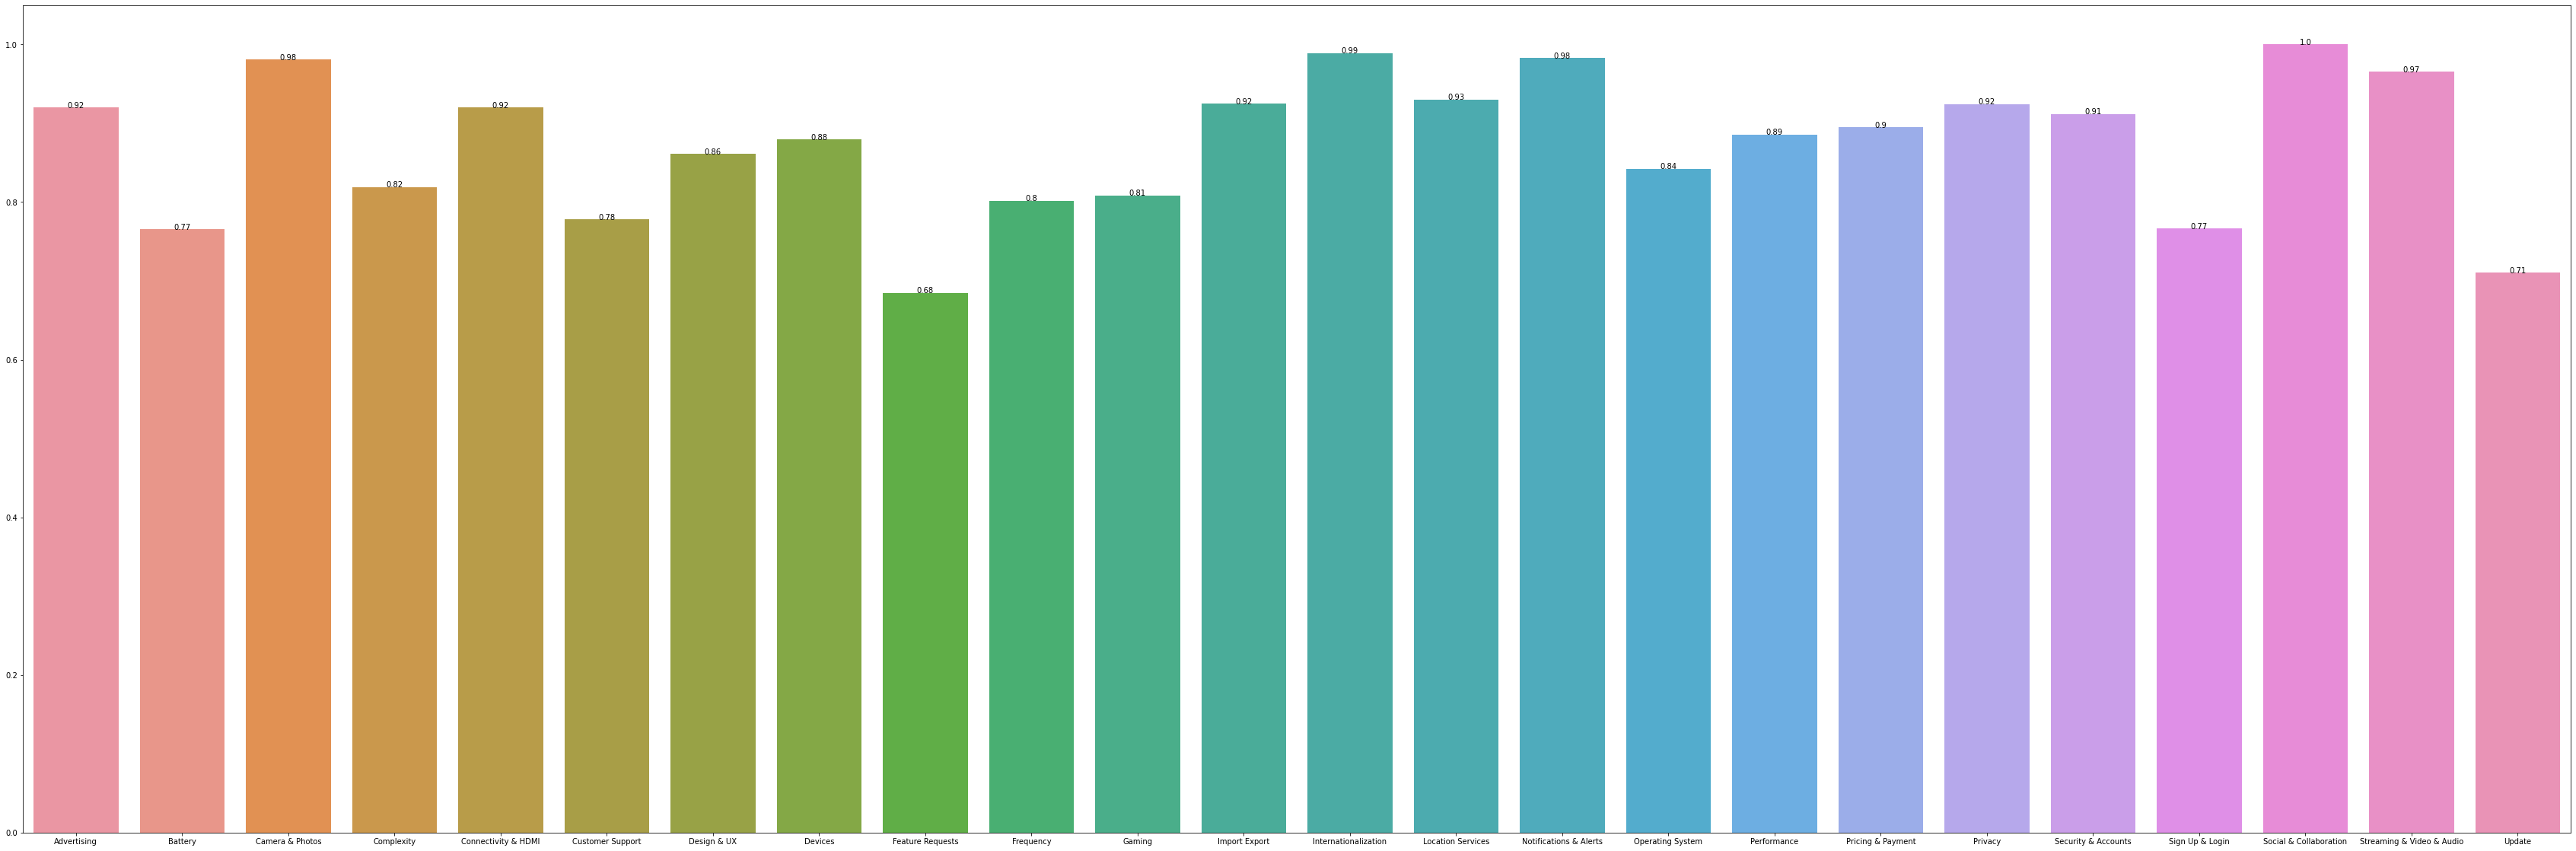

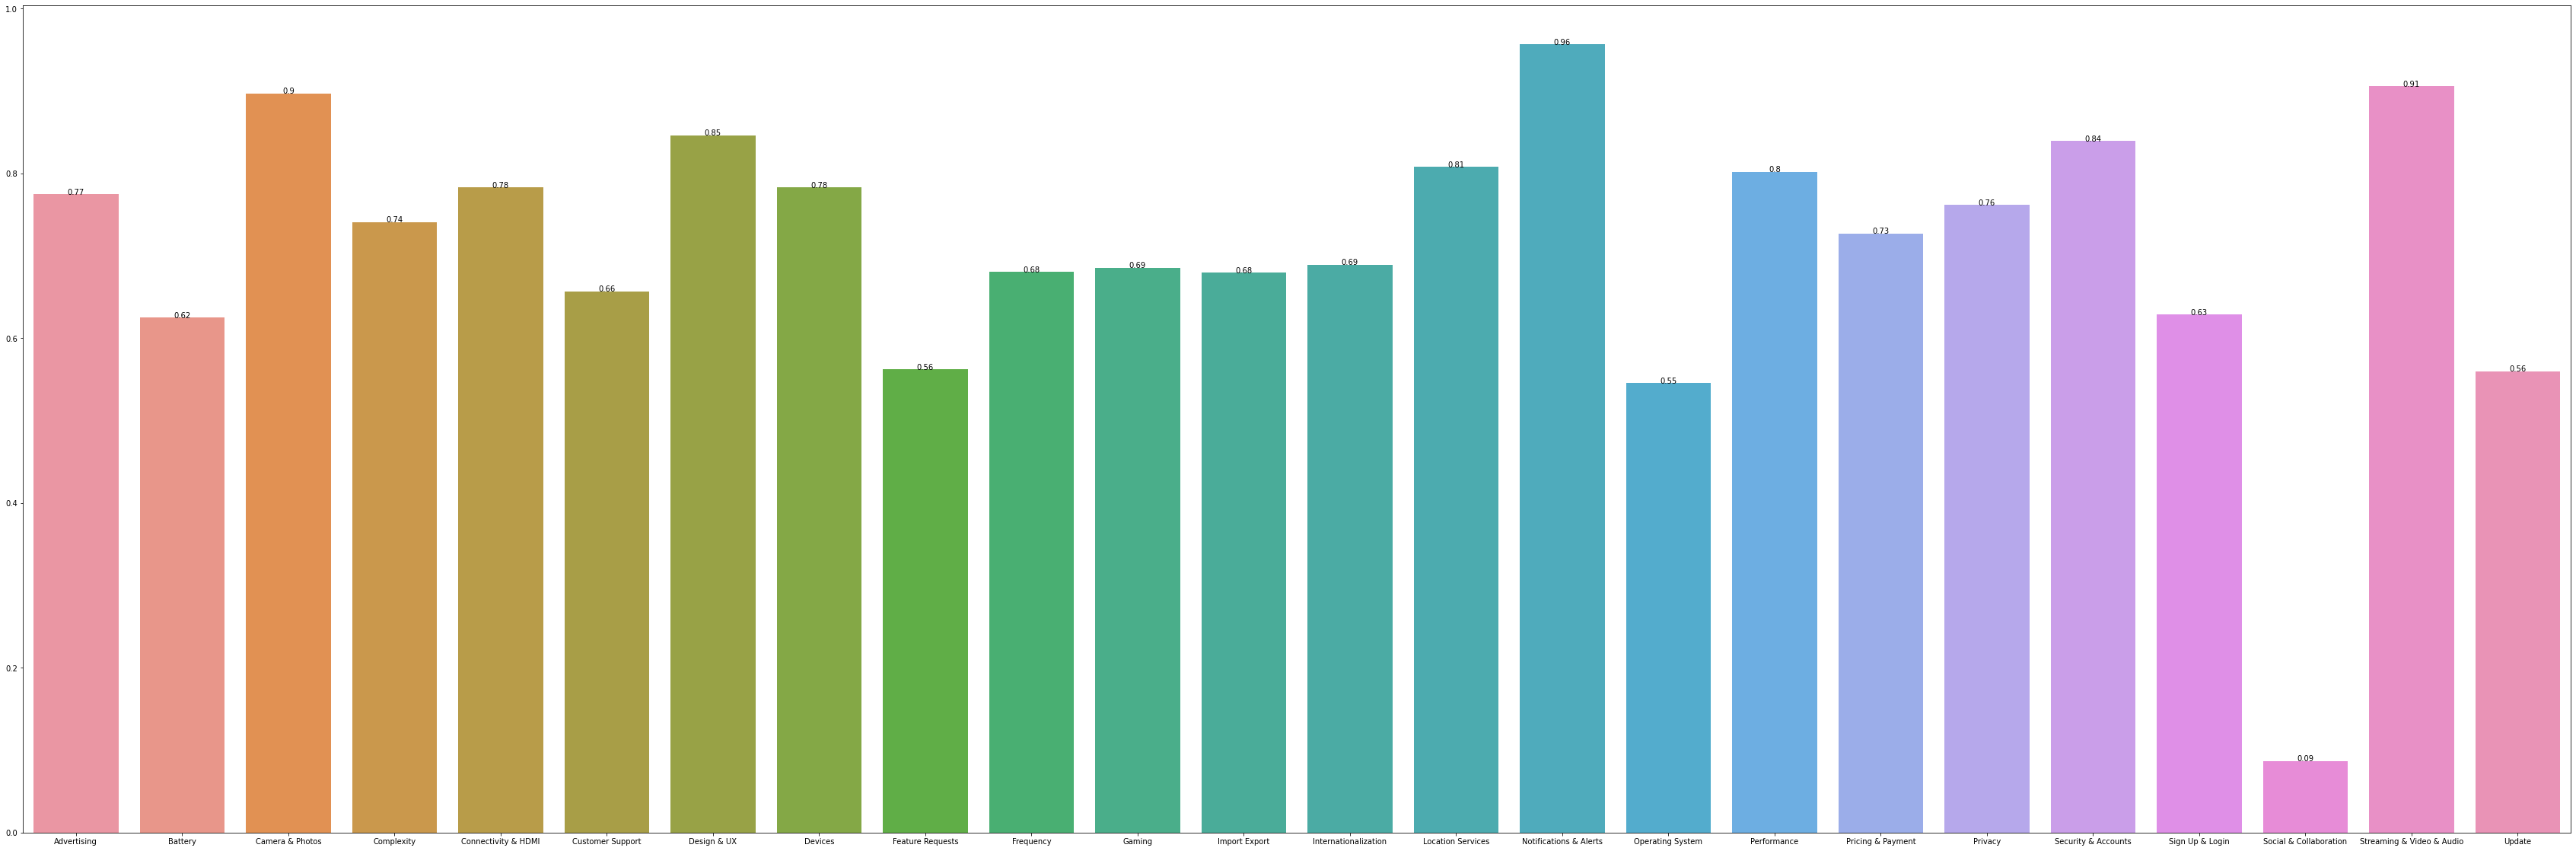

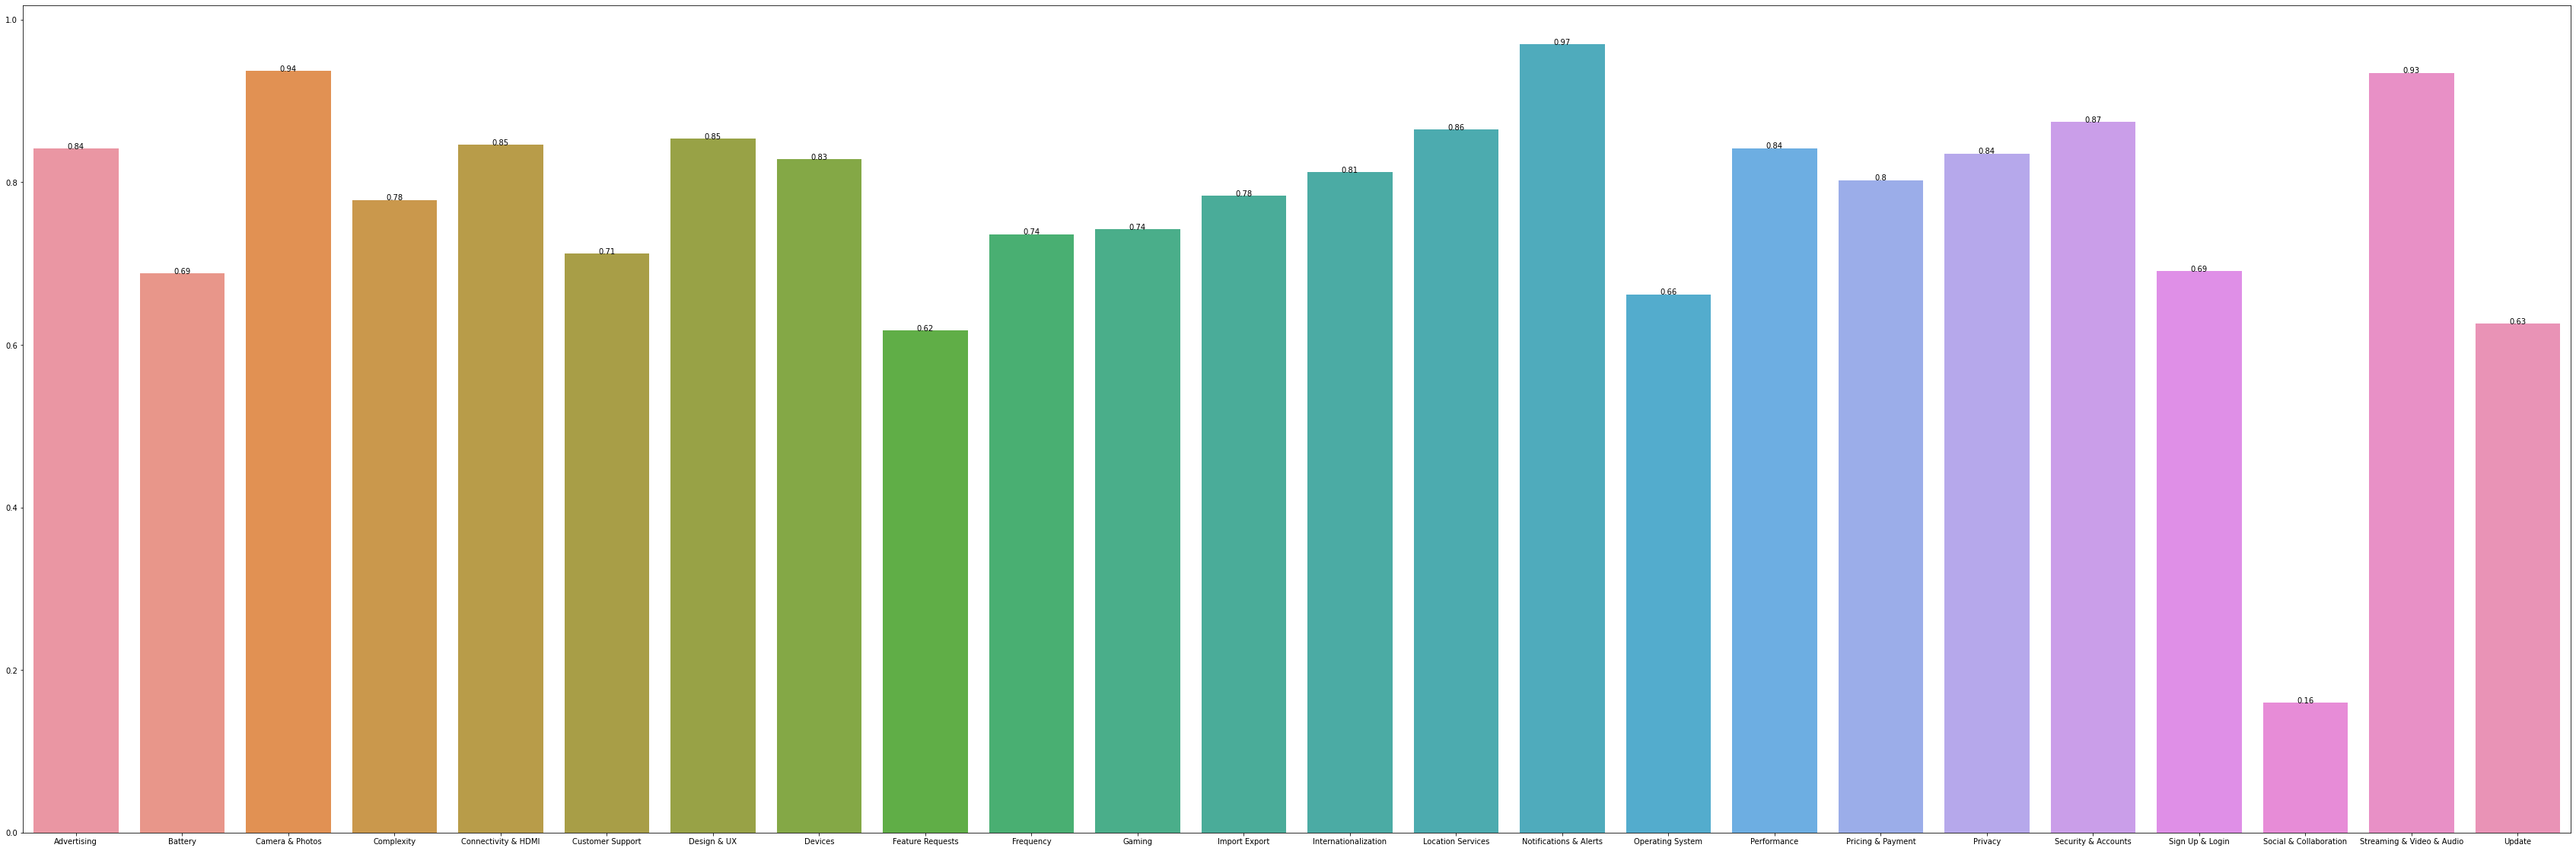

In [0]:
import numpy as np
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(60,20))
fig2 = plt.figure(figsize=(60,20))
fig3 = plt.figure(figsize=(60,20))
(ax_precision) = fig1.subplots(ncols=1, nrows=1)
( ax_f1) = fig2.subplots(ncols=1, nrows=1)
(ax_recall) = fig3.subplots(ncols=1, nrows=1)
g1 = sns.barplot(y=metrics[0], x=multilabel_binarizer.classes_, ax=ax_precision)
g2 = sns.barplot(y=metrics[1], x=multilabel_binarizer.classes_, ax=ax_f1)
g3 = sns.barplot(y=metrics[2], x=multilabel_binarizer.classes_, ax=ax_recall)
for i in range(num_classes):
    g1.text(i,metrics[0][i], round(metrics[0][i],2), color='black', ha="center")
    g2.text(i,metrics[1][i], round(metrics[1][i],2), color='black', ha="center")
    g3.text(i,metrics[2][i], round(metrics[2][i],2), color='black', ha="center")
fig1.savefig('gdrive/My Drive/All reviews/ax_precision_final.png')
fig2.savefig('gdrive/My Drive/All reviews/ax_f1_final.png')
fig3.savefig('gdrive/My Drive/All reviews/ax_recall_final.png')